In [70]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

import skimage
import skimage.data
import skimage.transform
import skimage.color

from IPython import display

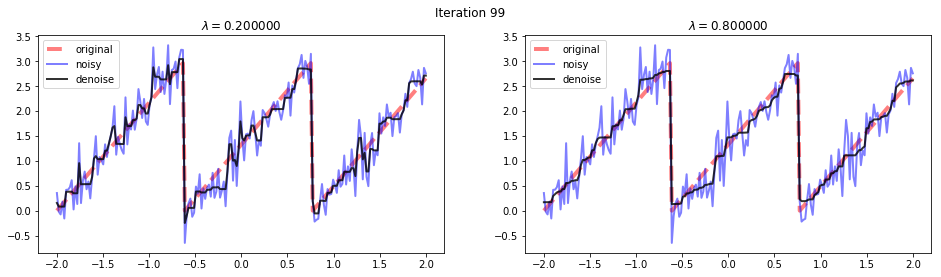

In [2]:
# 1D denoising
def shift(xs, h):
    assert isinstance(h, int)
    return np.hstack([xs[h:], [xs[-1]]*h] if h > 0 else [[xs[0]]*(-h), xs[:h]])

def sgd(xs):
    return np.sign(-xs)

def deltaJ(xs):
    return sgd(shift(xs, 1) - xs) + sgd(shift(xs, -1) - xs)

xs = np.linspace(-2, 2, 200)
us = (np.arange(len(xs)) / 23) % 3

us_noisy = us + np.random.randn(len(us)) * 0.3
gs = np.array(us_noisy)
us_denoise_1 = np.array(us_noisy)
us_denoise_2 = np.array(us_noisy)

w = 0.5
lambda_1 = 0.2
lambda_2 = 0.8

max_iter = 100
for i in range(max_iter):
    w *= 0.9    
    us_denoise_1 -= w*(us_denoise_1 - gs + lambda_1 * deltaJ(us_denoise_1))
    us_denoise_2 -= w*(us_denoise_2 - gs + lambda_2 * deltaJ(us_denoise_2))

    plt.close()
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    ax[0].plot(xs, us, color='red', label='original', linestyle='--', linewidth=4, alpha=0.5)
    ax[0].plot(xs, us_noisy, color='blue', label='noisy', linewidth=2, alpha=0.5)
    ax[0].plot(xs, us_denoise_1, color='black', label='denoise', linewidth=2, alpha=0.8)
    ax[0].set_title('$\\lambda = %f$' % lambda_1)
    ax[0].legend(loc='best')
    ax[1].plot(xs, us, color='red', label='original', linestyle='--', linewidth=4, alpha=0.5)
    ax[1].plot(xs, us_noisy, color='blue', label='noisy', linewidth=2, alpha=0.5)
    ax[1].plot(xs, us_denoise_2, color='black', label='denoise', linewidth=2, alpha=0.8)    
    ax[1].set_title('$\\lambda = %f$' % lambda_2)
    ax[1].legend(loc='best')
    plt.suptitle('Iteration %d' % i)
    
    display.display(plt.gcf())
    display.clear_output(wait=True)



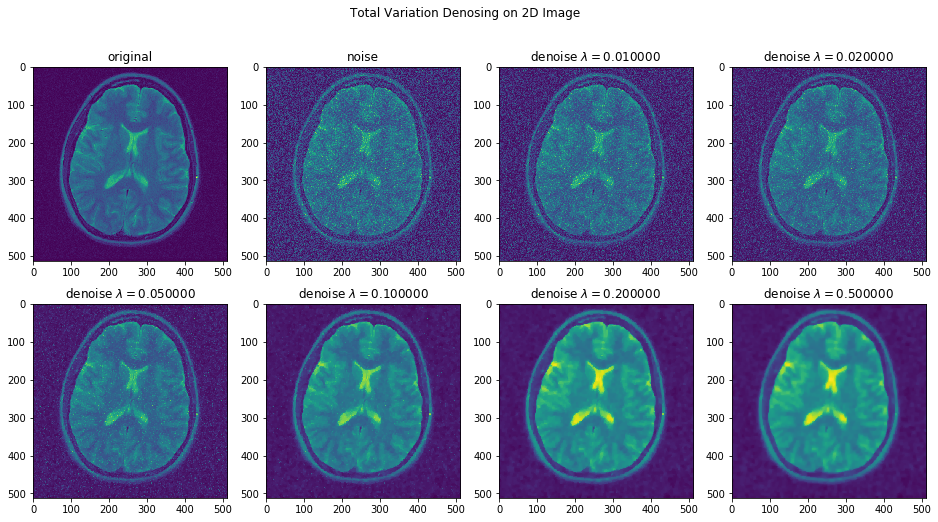

In [71]:
def denoising_2d(us, lmd, max_iter=100, return_history=False):
    u'''calculate denoising version of 2D array us'''

    us = np.array(us)
    gs = np.array(us)

    def xshift(xs, h):
        assert h==1 or h==-1
        return np.hstack([xs[:, h:], xs[:, -2:-1]] if h > 0 else [xs[:, 0:1], xs[:, :h]])

    def yshift(xs, h):
        assert h==1 or h==-1
        return np.vstack([xs[h:, :], xs[-2:-1, :]] if h > 0 else [xs[0:1, :], xs[:h, :]])

    def sgd(xs):
        return np.sign(-xs)

    def deltaJ(xs):
        return sgd(xshift(xs, 1) - xs) + sgd(xshift(xs, -1) - xs) + sgd(yshift(xs, 1) - xs) + sgd(yshift(xs, -1) - xs)

    us_history = [gs]
    w = 0.5

    for i in range(max_iter):
        us -= w*(us - gs + lmd*deltaJ(us))
        if return_history:
            us_history.append(np.array(list(us)))

        w *= 0.9

    if return_history:
        return us_history

    return us


# 2D test
brain_mat = loadmat('brain.mat')
img = np.abs(brain_mat['im'])
img_noise = img + np.abs(np.random.randn(*img.shape)) * 0.2
lmd = 0.3
img_denoise = denoising_2d(img_noise[:, :], lmd)

fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Total Variation Denosing on 2D Image')
axs[0, 0].imshow(img)
axs[0, 0].set_title('original')
axs[0, 1].imshow(img_noise)
axs[0, 1].set_title('noise')

denoise_axs = [axs[0, 2], axs[0, 3], axs[1, 0], axs[1, 1], axs[1, 2], axs[1, 3]]
for ax, lmd in zip(denoise_axs, [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]):
    ax.imshow(denoising_2d(img_noise[:, :], lmd))
    ax.set_title('denoise $\\lambda = %f$' % lmd)

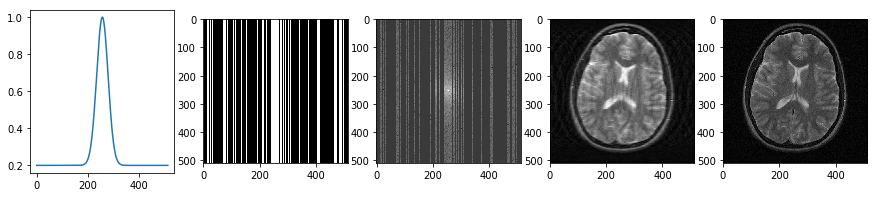

In [73]:
def normal_pdf(length, ivar):
    return np.exp(-ivar * (np.arange(length) - length / 2)**2)

brain_mat = loadmat('brain.mat')
img = np.abs(brain_mat['im'])
raw = np.fft.fft2(img)
raw = np.fft.fftshift(raw)

size = img.shape[0]
pdf = normal_pdf(size, 1e-3) / 1.25 + 0.20
xs = np.random.binomial(1, pdf)
mask = np.ones(img.shape)
mask = np.multiply(mask, xs)

masked_raw = np.multiply(raw, xs)
masked_img = np.fft.ifft2(masked_raw)

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
axs[0].plot(pdf)
axs[1].imshow(mask,cmap='gray')
axs[2].imshow(np.log10(np.abs(raw)**2)*mask, cmap='gray')
axs[3].imshow(np.abs(masked_img), cmap='gray')
axs[4].imshow(img, cmap='gray')

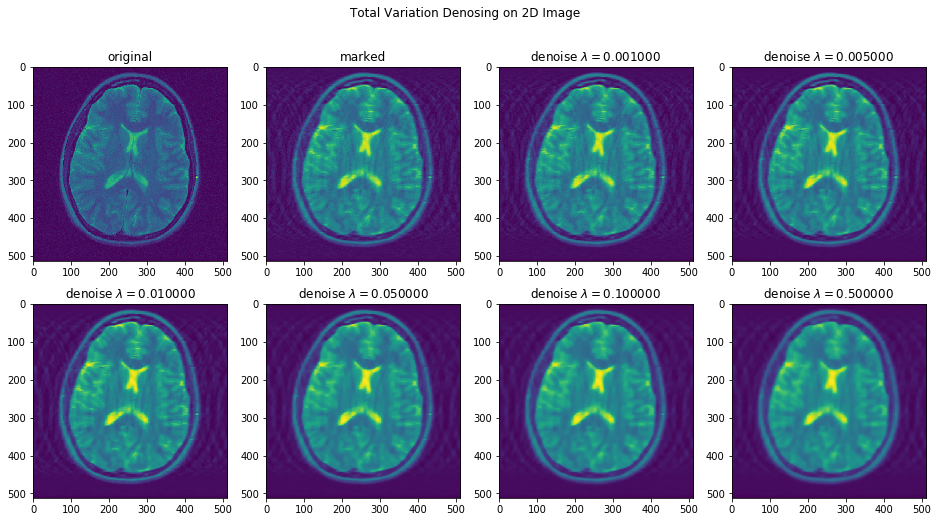

In [76]:
masked_image = np.abs(masked_img)

fig, axs = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Total Variation Denosing on 2D Image')
axs[0, 0].imshow(img)
axs[0, 0].set_title('original')
axs[0, 1].imshow(masked_image)
axs[0, 1].set_title('masked')

denoise_axs = [axs[0, 2], axs[0, 3], axs[1, 0], axs[1, 1], axs[1, 2], axs[1, 3]]
for ax, lmd in zip(denoise_axs, [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]):
    ax.imshow(denoising_2d(marked_image, lmd))
    ax.set_title('denoise $\\lambda = %f$' % lmd)